## Análise de Resultados - Live Trading Portfolio

### Considerações iniciais

Nesta análise exploratória irei obter os dados de performance mais relevantes para um porfolio de algoritmos que rodou em Live Trading por 1 ano. <br>

Iremos explorar as principais métricas relacionadas a avaliação de performance, focando na comparação do portfolio com a aplicação buy and hold no benchmark de referência. <br><br>
Depósito inicial: `$ 50.000,00`<br>


#### Carregando o arquivo de relatório de performance e importando bibliotecas

In [1185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
import yfinance as yf
from scipy.stats import linregress
from bcb import sgs
import warnings

# Datas
inicio = '2023-08-26'
fim = '2024-08-26'

# Depósito
initial_deposit = 50000

# Carregar arquivo importado do mt5
#ile_path = r'G:\Meu Drive\Box\Projects\Production\ReportHistory-201061_1year.xlsx'
file_path = 'https://raw.githubusercontent.com/davimmoraes/live_trading_portfolio_analysis/master/ReportHistory-201061_1year.xlsx'
df = pd.read_excel(file_path)
warnings.simplefilter("ignore", UserWarning)

#### É necessário fazer a limpeza e tratamento dos dados para obter o dataframe correto

In [1186]:
# Vamos recarregar a planilha Excel em um dataframe, ignorando as primeiras 6 linhas (que contêm metadados do relatório)
df = pd.read_excel(file_path, skiprows=6)

# Encontre a posição da linha que contém "Orders"
orders_index = df[df.apply(lambda row: row.astype(str).str.contains('Orders', case=False).any(), axis=1)].index

if not orders_index.empty:
    # Pegue o índice da primeira ocorrência de "Orders"
    orders_index = orders_index[0]
    
    # Mantenha apenas as linhas acima do índice encontrado
    df = df.iloc[:orders_index]
    
    # Reinicie o índice do dataframe
    df.reset_index(drop=True, inplace=True)    

    # Verifique se a coluna "Profit" está presente
    if 'Profit' in df.columns:
        # Converta a coluna "Profit" para valores numéricos, forçando erros a NaN
        df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')

        # Remova as linhas onde 'Profit' é NaN
        df = df.dropna(subset=['Profit'])
    else:
        print("A coluna 'Profit' não foi encontrada.")
else:
    print("A palavra 'Orders' não foi encontrada no DataFrame.")

#### Com o dataframe pronto, calculamos o lucro total do sistema e plotamos a sua curva de capital<br>
Vamos criar também um novo dataframe para armazenar as métricas de performance que serão calculadas, começamos armenando o lucro total do sistema e seu CAGR (crescimento anual composto).

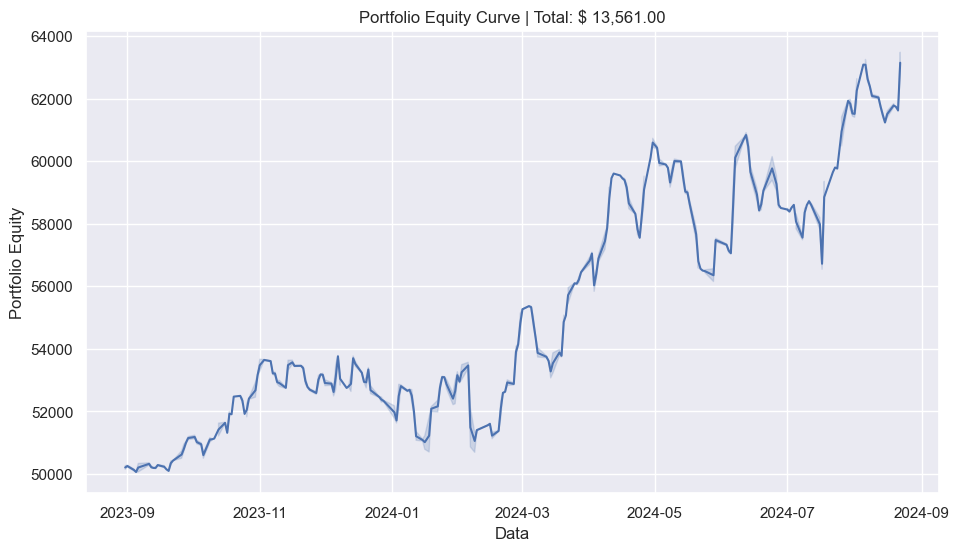

,Métrica,Portfolio
0,Deposit,$ 50000.00
1,Lucro,$ 13625.00
2,CAGR,27.96%


In [1187]:
# Calcule a soma de todas as linhas da coluna "Profit"
system_profit = df['Profit'].sum()
#print("\nSoma total da coluna 'Profit'", total_profit)

# Calcule a soma acumulada da coluna "Profit"
df['Portfolio PnL'] = df['Profit'].cumsum()
df['Portfolio Equity'] = initial_deposit + df['Profit'].cumsum()
df['Time'] = pd.to_datetime(df['Time'])
df['Data'] = df['Time']
df['Data'] = pd.to_datetime(df['Data'])
df = df[(df['Data'] >= pd.to_datetime(inicio)) & (df['Data'] <= pd.to_datetime(fim))]
df['Data'] = df['Time'].dt.date

valor_final_portfolio = initial_deposit + df['Portfolio PnL'].iloc[-1]

# CAGR
valor_final_portfolio = initial_deposit + df['Portfolio PnL'].iloc[-1]
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr = (valor_final_portfolio/ initial_deposit) ** (1 / num_anos) - 1
cagr *= 100


df_metricas = pd.DataFrame({'Métrica': ['Deposit','Lucro','CAGR'],'Portfolio': [f'$ {initial_deposit:.2f}',f"$ {df['Portfolio PnL'].iloc[-1]:.2f}",f"{cagr:.2f}%"]
})



plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Data', y='Portfolio Equity')
plt.title(f'Portfolio Equity Curve | Total: {f"$ {system_profit:,.2f}"}')
plt.show()
df_metricas

#### Calculando a exposição a risco máxima do portfolio (drawdown)

   Portfolio Equity   Returns
0             50150  0.000000
1             50267  0.002330
2             50288  0.000418
3             50309  0.000418
4             50247 -0.001233


,Métrica,Portfolio
0,Deposit,$ 50000.00
1,Lucro,$ 13625.00
2,CAGR,27.96%
3,Drawdown Max ($),$ -5038.00
4,Drawdown Max (%),-8.28%


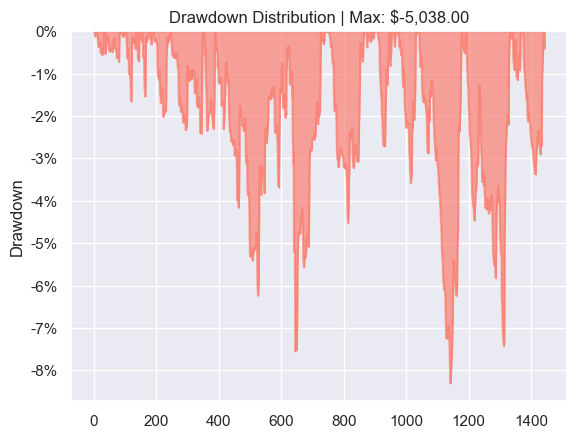

In [1188]:
# Calcular o valor máximo acumulado até cada ponto
df['Max_Peak'] = df['Portfolio Equity'].cummax()

# Calcular o drawdown em termos financeiros
df['Drawdown'] = df['Portfolio Equity'] - df['Max_Peak']

# Encontrar o drawdown máximo financeiro
max_drawdown_financeiro_portfolio = df['Drawdown'].min()

# Encontrar a data em que ocorreu o maior drawdown
data_max_drawdown_portfolio = df[df['Drawdown'] == max_drawdown_financeiro_portfolio]['Data'].values[0]

# Obter o valor do Max_Peak na data do maior drawdown
max_peak_at_drawdown_portfolio = df[df['Data'] == data_max_drawdown_portfolio]['Max_Peak'].values[0]

# Calcular o drawdown máximo em termos percentuais
max_drawdown_percent_portfolio = (max_drawdown_financeiro_portfolio / max_peak_at_drawdown_portfolio) * 100

df_metricas__portfolio_drawdown = pd.DataFrame({
    'Métrica': ['Drawdown Max ($)', 
                'Drawdown Max (%)'],
    'Portfolio': [f"$ {max_drawdown_financeiro_portfolio:.2f}", 
              f"{max_drawdown_percent_portfolio:.2f}%"]
})

df_metricas = pd.concat([df_metricas,df_metricas__portfolio_drawdown], ignore_index=True)

# Calcular retornos
df['Returns'] = np.log(df['Portfolio Equity'] / df['Portfolio Equity'].shift(1)).fillna(0)

# Verificar se o cálculo dos retornos faz sentido
print(df[['Portfolio Equity', 'Returns']].head())

# Plotar o drawdown usando pyfolio
pf.plot_drawdown_underwater(df['Returns'])
plt.title(f'Drawdown Distribution | Max: ${max_drawdown_financeiro_portfolio:,.2f}')


df_metricas

In [1189]:
# Printar drawdown financeiro máximo sobre o depósito
print(max_drawdown_financeiro_portfolio/initial_deposit*100)

-10.076


Observamos um drawdown máximo de -R\$5.038, o que representa um drawdown de 8.28% no momento em que o mesmo aconteceu, e um drawdown máximo de 10,07% sobre o valor de depósito.

#### Distribuição de resultado dos trades

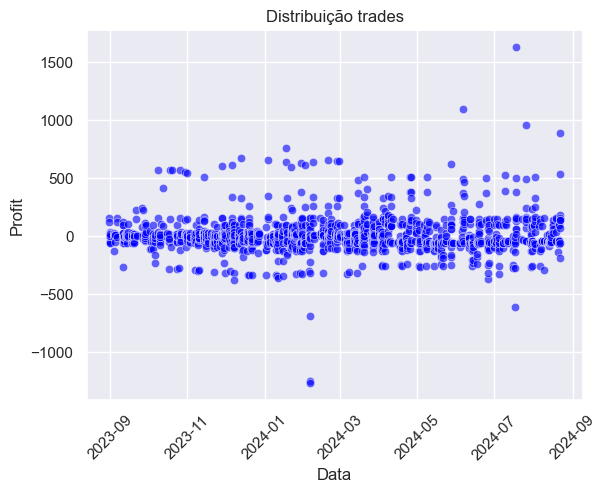

In [1190]:
sns.scatterplot(data=df, x='Data', y='Profit', color='blue', alpha=0.6)
# Adicionar detalhes ao gráfico
plt.title('Distribuição trades')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.show()

Percebe-se uma distruibução uniforme, e os poucos outliers que aparecem existem tanto para trades perdedores quanto para trades vencedores.

#### Calculando a volatilidade do portfolio

In [1191]:
# Calcular os retornos diários
retornos_diarios_portfolio = (initial_deposit + df['Portfolio PnL']).pct_change().dropna()

# Calcular a volatilidade (desvio padrão dos retornos diários)
volatilidade_diaria_portfolio = retornos_diarios_portfolio.std() * 100
dias_de_negociacao_por_ano = 252
volatilidade_anualizada_portfolio = volatilidade_diaria_portfolio * np.sqrt(dias_de_negociacao_por_ano)

df_metricas_portfolio_vol = pd.DataFrame({
    'Métrica': ['Volatilidade Diária', 'Volatilidade Anual'],
    'Portfolio': [f"{volatilidade_diaria_portfolio:.2f}%", f"{volatilidade_anualizada_portfolio:.2f}%"]
})

df_metricas = pd.concat([df_metricas, df_metricas_portfolio_vol], ignore_index=True)

df_metricas

,Métrica,Portfolio
0,Deposit,$ 50000.00
1,Lucro,$ 13625.00
2,CAGR,27.96%
3,Drawdown Max ($),$ -5038.00
4,Drawdown Max (%),-8.28%
5,Volatilidade Diária,0.29%
6,Volatilidade Anual,4.67%


#### Obtendo dados do benchmark - Ibovespa<br>

In [1192]:
# Coletar dados da API
symbol = '^BVSP'
df_benchmark = yf.download(symbol, start=inicio, end=fim)
close_prices_benchmark = df_benchmark['Close']

[*********************100%***********************]  1 of 1 completed


##### Calculando retornos, drawdown máximo e volatilidade do benchmark e adicionando ao dataframe

Text(0.5, 1.0, 'Ibovespa')

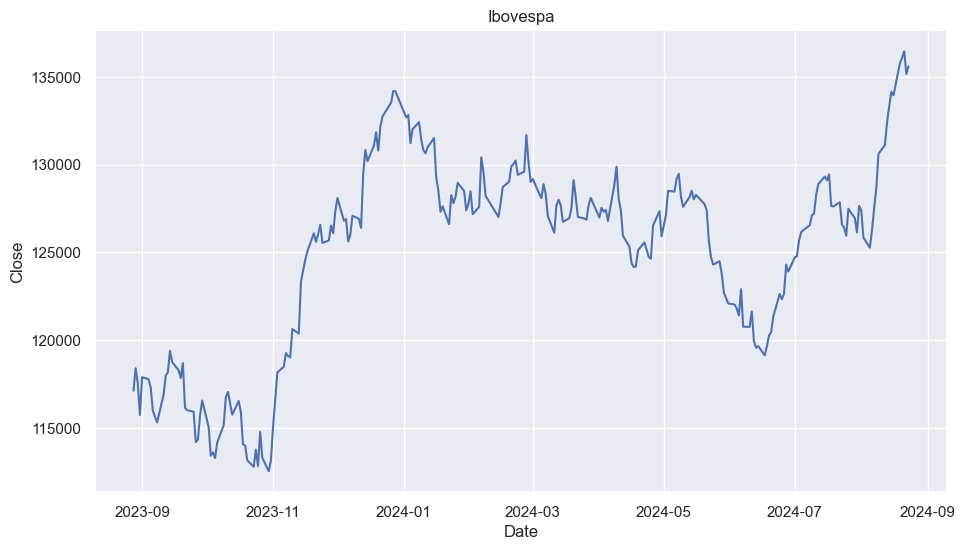

In [1193]:
# Normalizar o preço de fechamento para refletir o depósito inicial
close_prices_normalized_benchmark = (close_prices_benchmark / close_prices_benchmark.iloc[0]) * initial_deposit

# Calcular o retorno absoluto total
preco_inicial_benchmark = close_prices_normalized_benchmark.iloc[0]
preco_final_benchmark = close_prices_normalized_benchmark.iloc[-1]
retorno_absoluto_total_benchmark = (preco_final_benchmark - preco_inicial_benchmark) / preco_inicial_benchmark

# Calcular os retornos diários
retornos_diarios_benchmark = close_prices_normalized_benchmark.pct_change().dropna()

# Calcular o drawdown máximo
acumulado_benchmark= close_prices_normalized_benchmark.cummax()
drawdown_benchmark= (close_prices_normalized_benchmark - acumulado_buyhold) / acumulado_buyhold

# Encontrar a data do drawdown máximo
data_max_drawdown_benchmark = drawdown_benchmark.idxmin()

# Obter o valor do acumulado máximo na data do maior drawdown
max_peak_at_drawdown_benchmark = acumulado_benchmark.loc[data_max_drawdown_benchmark]

# Valor financeiro do drawdown máximo
drawdown_maximo_financeiro_benchmark = (drawdown_benchmark.loc[data_max_drawdown_benchmark]) * initial_deposit

# Calcular o drawdown máximo percentual a partir do pico financeiro
drawdown_maximo_percentual_benchmark = (drawdown_maximo_financeiro_benchmark / max_peak_at_drawdown_benchmark) * 100

# Calcular os retornos diários
retornos_diarios_benchmark = close_prices_normalized_benchmark.pct_change().dropna()

# Converter para uma série temporal com as datas como índice
series_retorno_benchmark = pd.Series(data=retornos_diarios_benchmark, index=retornos_diarios_benchmark.index)

# Calcular a volatilidade (desvio padrão dos retornos diários)
volatilidade_diaria_benchmark = retornos_diarios_benchmark.std() * 100

# Calcular a volatilidade anualizada (multiplicando pela raiz quadrada do número de dias de negociação por ano)
dias_de_negociacao_por_ano = 252
volatilidade_anualizada_benchmark = volatilidade_diaria_benchmark * np.sqrt(dias_de_negociacao_por_ano)

# Calcular lucro do buy and hold no benchmark
lucro_benchmark = retorno_absoluto_total_benchmark*initial_deposit
valor_final_benchmark = initial_deposit + lucro_benchmark
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr_benchmark= (valor_final_benchmark / initial_deposit) ** (1 / num_anos) - 1
cagr_benchmark *= 100

# Agora, adicione uma nova coluna ao dataframe 'df_metricas'
df_metricas['Benchmark'] = [
    f'$ {initial_deposit:.2f}',  # Supondo que você não tem valores correspondentes para 'Deposit' na linha 0
    f'$ {lucro_benchmark:.2f}',  # Nem para 'System Profit' na linha 1
    f'{cagr_benchmark:.2f}%',  # Nem para 'CAGR' na linha 2
    f"$ {drawdown_maximo_financeiro_benchmark:.2f}",  # Drawdown Máximo ($) na linha 3
    f"{drawdown_maximo_percentual_benchmark:.2f}%",  # Drawdown Máximo (%) na linha 4
    f"{volatilidade_diaria_benchmark:.2f}%",  # Volatilidade Diária na linha 5
    f"{volatilidade_anualizada_benchmark:.2f}%",  # Volatilidade Anualizada na na linha 6
]

# Resultados
plt.figure(figsize=(11, 6))
sns.lineplot(close_prices_benchmark)
plt.title('Ibovespa')

In [1194]:
df_metricas

,Métrica,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Lucro,$ 13625.00,$ 7892.27
2,CAGR,27.96%,16.18%
3,Drawdown Max ($),$ -5038.00,$ -5609.79
4,Drawdown Max (%),-8.28%,-9.79%
5,Volatilidade Diária,0.29%,0.83%
6,Volatilidade Anual,4.67%,13.13%


In [1195]:
# Printar drawdown financeiro máximo sobre o depósito
print(drawdown_maximo_financeiro_benchmark/initial_deposit*100)

-11.219577626421453


Observamos um drawdown financeiro máximo de -R\$5.609.79, o que representa um drawdown de 9.79% no momento em que o mesmo aconteceu, e um drawdown máximo de 11,21% sobre o valor de depósito.

Consideramos a alocação financeira do valor total do depósito inicial no benchmark, a título de comparação.<br>

Observamos que durante o período analisado o benchmark se valorizou em 16.18%, um valor considerável considerando ser um mercado emergente e a janela de observação de 1 ano.<br>
Observamos o drawdown de 11.22%, valor próximo ao drawdown observado no sistema.<br>


Sua volatilidade anual foi de 13.13%, um valor expressivamente maior do que o do sistema (4.66%). <br>


Vamos também calcular as regressões lineares para o portfolio e o benchmark.

#### Calculando a regressão linear do portfolio

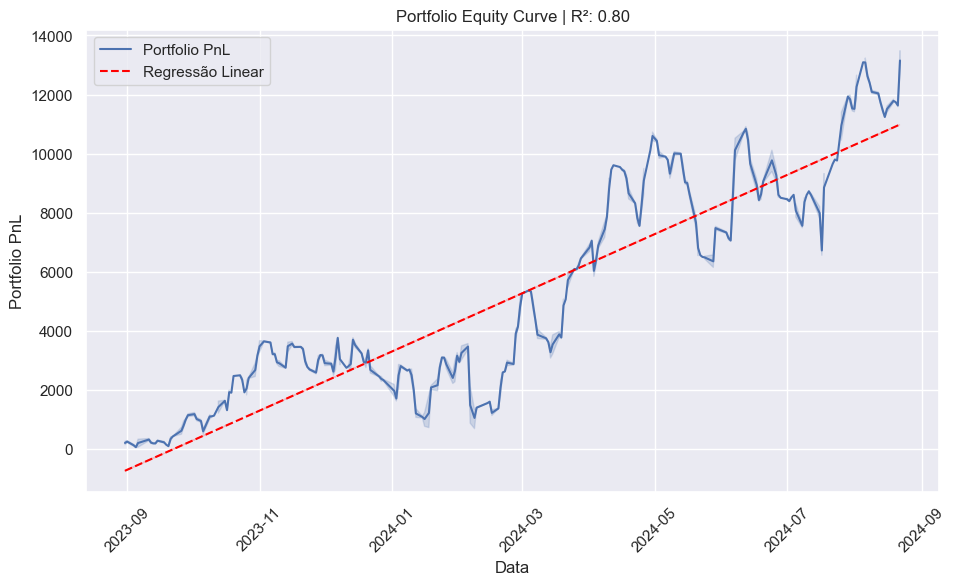

In [1196]:
# Converta a coluna de datas em números para a regressão
df['Time_ordinal'] = df['Time'].map(pd.Timestamp.toordinal)

# Calcular a regressão linear
slope, intercept, r_value, p_value, std_err = linregress(df['Time_ordinal'], df['Portfolio PnL'])

# Calcular o R²
r_squared = r_value**2

# Adicionar a linha de regressão ao DataFrame
df['Regressao'] = intercept + slope * df['Time_ordinal']

# Adicionar R² ao nosso dataframe de métricas
df_metricas_portfolio_lr = pd.DataFrame({'Métrica':['Curve Smoothness - R²'],'Portfolio':[f'{r_squared:.2f}']})
df_metricas = pd.concat([df_metricas, df_metricas_portfolio_lr], ignore_index=True)

# Plotar o gráfico
plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Data', y='Portfolio PnL', label='Portfolio PnL')
sns.lineplot(data=df, x='Data', y='Regressao', color='red', linestyle='--', label='Regressão Linear')

plt.title(f'Portfolio Equity Curve | R²: {r_squared:.2f}')
plt.xlabel('Data')
plt.ylabel('Portfolio PnL')
plt.xticks(rotation=45)
plt.legend()
plt.show()

O R² representa o quanto o modelo linear consegue descrever os dados, o que para nós representa aqui a estabilidade da curva de capital. Com um R² de 0.81, o portfolio apresenta uma estabilidade na distribuição de ganhos satisfatória.

##### Calculando regressão linear do benchmark

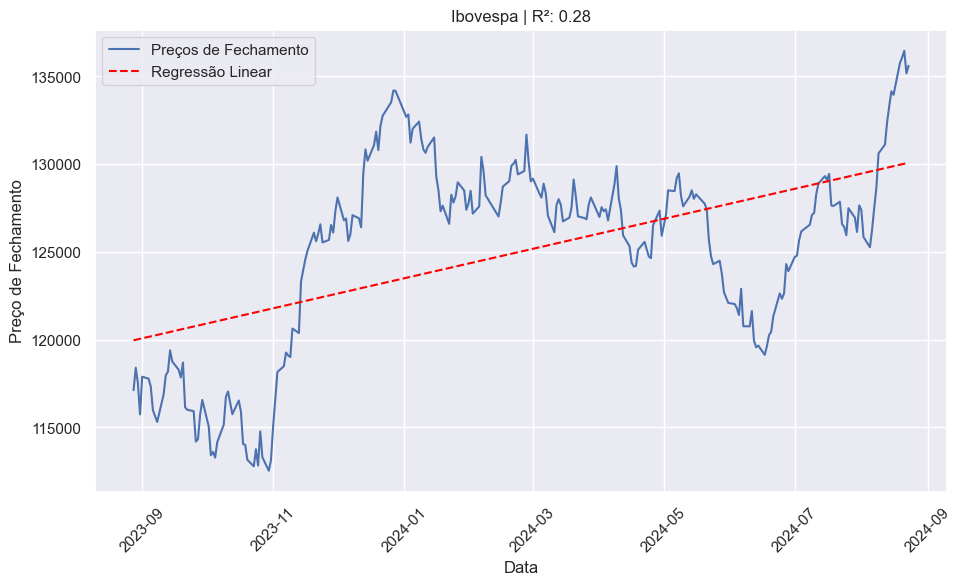

In [1197]:
df_benchmark.reset_index(inplace=True)  # Resetar o índice para usar a coluna de datas

# Converter a coluna de datas em números para a regressão
df_benchmark['Time_ordinal'] = df_benchmark['Date'].map(pd.Timestamp.toordinal)

# Calcular a regressão linear
slope_benchmark, intercep_benchmark, r_value_benchmark, p_value_benchmark, std_err_benchmark = linregress(df_benchmark['Time_ordinal'], df_benchmark['Close'])

# Calcular o R²
r_squared_benchmark = r_value_benchmark**2

# Adicionar a linha de regressão ao DataFrame
df_benchmark['Regressao'] = intercep_benchmark + slope_benchmark * df_benchmark['Time_ordinal']

# Adicionar métrica ao dataframe
df_metricas.loc[df_metricas['Métrica'] == 'Curve Smoothness - R²', 'Benchmark'] = f'{r_squared_benchmark:.2f}'




# Plotar o gráfico
plt.figure(figsize=(11, 6))
sns.lineplot(data=df_benchmark, x='Date', y='Close', label='Preços de Fechamento')
sns.lineplot(data=df_benchmark, x='Date', y='Regressao', color='red', linestyle='--', label='Regressão Linear')

plt.title(f'Ibovespa | R²: {r_squared_benchmark:.2f}')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Observamos um valor R² de 0.28, inferior ao do portfolio em estudo que possui 0.81.<br>

#### Calculando métricas de performance do sistema: fator de recuperação, taxa de acerto, payoff, edge, fator de lucro, e expectativa matemática

In [1198]:
# Filtrar operações vencedoras e perdedoras
num_vencedoras = df[df['Profit'] > 0].shape[0]
num_total = df.shape[0]

# Calcular a taxa de acerto
taxa_acerto = (num_vencedoras / num_total) * 100 if num_total > 0 else 0

# Filtrar operações vencedoras e perdedoras
vencedoras = df[df['Profit'] > 0]['Profit']
perdedoras = df[df['Profit'] < 0]['Profit']

# Calcular a média das operações vencedoras e perdedoras
media_vencedoras = vencedoras.mean() if not vencedoras.empty else 0
media_perdedoras = perdedoras.mean() if not perdedoras.empty else 0

payoff = media_vencedoras/-media_perdedoras

# Calcular o breakeven
breakeven = (1 / (1+payoff))*100

# Calculando edge
edge = taxa_acerto - breakeven

# Fator de Lucro
soma_lucros = df[df['Profit'] > 0]['Profit'].sum()
soma_perdas = df[df['Profit'] < 0]['Profit'].sum()
fator_lucro = soma_lucros / abs(soma_perdas) if soma_perdas != 0 else np.nan

# Expectativa Matemática
payoff_medio = media_vencedoras / -media_perdedoras
expectancy = (taxa_acerto / 100 * payoff_medio) - ((100 - taxa_acerto) / 100)
expectancy *= 100

# Fator de Recuperação
recovery_factor = (system_profit / -max_drawdown_financeiro)


df_metricas_performance = pd.DataFrame({
    'Métrica': ['Fator Recuperação',
                'Taxa de Acerto', 
                'Payoff', 
                'Edge', 
                'Fator de Lucro',                 
                'Expectativa Matemática',],
    'Portfolio': [f'{recovery_factor:.2f}',
              f"{taxa_acerto:.2f}%", 
              f"{payoff:,.2f}", 
              f"{edge:,.2f}%", 
              f"{fator_lucro:.2f}", 
              f"{expectancy:.2f}%"
              ]
})

df_metricas = pd.concat([df_metricas, df_metricas_performance], ignore_index=True)

df_metricas

,Métrica,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Lucro,$ 13625.00,$ 7892.27
2,CAGR,27.96%,16.18%
3,Drawdown Max ($),$ -5038.00,$ -5609.79
4,Drawdown Max (%),-8.28%,-9.79%
5,Volatilidade Diária,0.29%,0.83%
6,Volatilidade Anual,4.67%,13.13%
7,Curve Smoothness - R²,0.80,0.28
8,Fator Recuperação,2.69,NaN
9,Taxa de Acerto,47.92%,NaN


Para calcularmos indicadores de retorno ajustado ao risco, é necessário obtermos a taxa Selic do período.

#### Calculando a taxa Selic para o período

Valor médio da taxa Selic no período: 11.45%


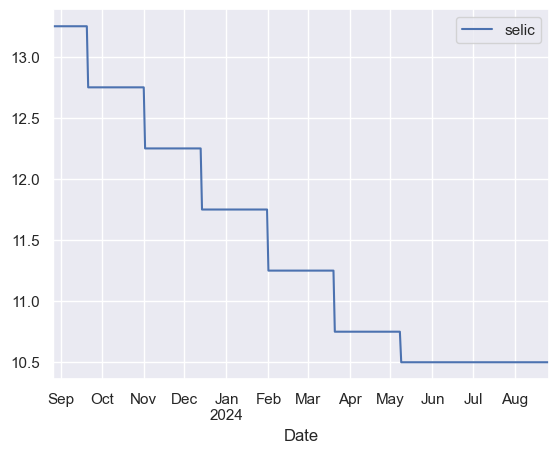

In [1199]:
# Obtem dados da API do Banco Central
selic = sgs.get({'selic': 432},start = inicio,end = fim)

valor_medio_selic = selic['selic'].mean()
taxa_livre_risco = valor_medio_selic/100

#Visualizar dados
sns.set_theme()
#selic.plot(figsize=(15,20))
selic.plot()
print(f"Valor médio da taxa Selic no período: {valor_medio_selic:.2f}%")


Interessante notar que há um claro cenário de afrouxamento da política monetária no período.

#### Calculando mais indicadores de performance 

In [1200]:
# Sharpe Ratio
retorno_sistema = (system_profit)/initial_deposit
desvio_padrao = df['Profit'].std() / initial_deposit
sharpe_ratio = (retorno_sistema - taxa_livre_risco) / (volatilidade_anualizada_portfolio/100) if desvio_padrao != 0 else np.nan

# Calmar Ratio
retorno_anual_portfolio = (valor_final_portfolio/ initial_deposit - 1) * 100
calmar_ratio = retorno_anual_portfolio / abs(max_drawdown_financeiro_portfolio) if max_drawdown_financeiro_portfolio != 0 else np.nan

# VaR
conf_level = 0.95
var = df['Profit'].quantile(1 - conf_level)

# Expectancy
payoff_medio = media_vencedoras / -media_perdedoras
expectancy = (taxa_acerto / 100 * payoff_medio) - ((100 - taxa_acerto) / 100)
expectancy *= 100

# AHPR (Assumindo que cada trade é independente e os retornos são médios diários)
ahpr = df['Profit'].mean()

# GHPR
geometric_return = np.exp(np.log1p(df['Profit']).mean()) - 1

df_metricas_risco = pd.DataFrame({
    'Métrica': ['Sharpe Ratio', 
                'Calmar Ratio', 
                'VaR (95%)', 
                'AHPR', 
                'GHPR'],
    'Portfolio': [f"{sharpe_ratio:.2f}", 
              f"{calmar_ratio:,.2f}", 
              f"{var:,.2f}", 
              f"{ahpr:.2f}", 
              f"{geometric_return:.2f}%"]
})

df_metricas = pd.concat([df_metricas, df_metricas_risco], ignore_index=True)


# Calculando métricas aplicáveis ao benchmark
# Calcular fator de recuperação do ibov
fr_benchmark = lucro_benchmark / -drawdown_maximo_financeiro_benchmark

df_metricas.loc[df_metricas['Métrica'] == 'Fator Recuperação', 'Benchmark'] = f'{fr_benchmark:.2f}'

# Exibindo os resultados

# print(f"CAGR: {cagr*100:.2f}%")
# print(f'Drawdown max: {max_drawdown_financeiro*100/initial_deposit:.2f}%')
# print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
# print(f"Calmar Ratio: {calmar_ratio:.2f}")
# print(f"VaR (95%): $ {var:,.2f}")
# print(f"AHPR: {ahpr:.2f}")
# print(f"GHPR: {geometric_return*100:.2f}%")

c:\Users\davim\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\davim\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Calculando métricas de performance aplicáveis ao benchmark

Nem todas métricas de performance são aplicáveis à comparação com o benchmark. Por exemplo, o payoff representa a média entre operações vencedoras e perdedoras, o que não faz sentido calcular para o benchmark pois está sendo considerado apenas o buy and hold teórico*.


###### *Ibovespa é uma carteira teórica, porém a operação poderia ser realizada facilmente através de um ETF que acompanha o índice, por exemplo.

In [1201]:
# Calcular fator de recuperação do ibov
fr_buyhold = lucro_benchmark / -drawdown_maximo_financeiro_benchmark

# Sharpe Ratio
retorno_benchmark = (lucro_benchmark)/initial_deposit
sharpe_ratio_benchmark = (retorno_benchmark - taxa_livre_risco) / (volatilidade_anualizada_benchmark/100)


# Adicionar métricas ao df
df_metricas.loc[df_metricas['Métrica'] == 'Fator Recuperação', 'Benchmark'] = f'{fr_benchmark:.2f}'
df_metricas.loc[df_metricas['Métrica'] == 'Sharpe Ratio', 'Benchmark'] = f'{sharpe_ratio_benchmark:.2f}'

### Avaliando resultados

Vamos agora analisar as métricas calculadas e plotar novamente os dois gráficos lado a lado para comparação.

,Métrica,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Lucro,$ 13625.00,$ 7892.27
2,CAGR,27.96%,16.18%
3,Drawdown Max ($),$ -5038.00,$ -5609.79
4,Drawdown Max (%),-8.28%,-9.79%
5,Volatilidade Diária,0.29%,0.83%
6,Volatilidade Anual,4.67%,13.13%
7,Curve Smoothness - R²,0.80,0.28
8,Fator Recuperação,2.69,1.41
9,Taxa de Acerto,47.92%,N/A


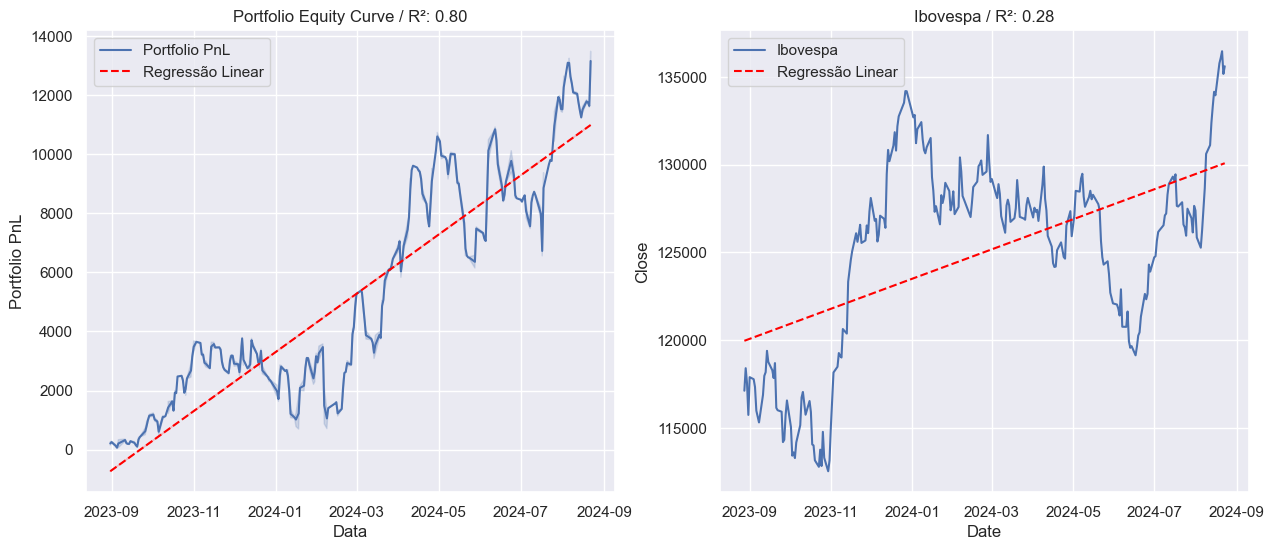

In [1202]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 linha, 2 colunas

sns.lineplot(data=df, x='Data', y='Portfolio PnL', label='Portfolio PnL',ax=axes[0])
sns.lineplot(data=df, x='Data', y='Regressao', color='red', linestyle='--', label='Regressão Linear', ax=axes[0])
axes[0].set_title(f'Portfolio Equity Curve / R²: {r_squared:.2f}')

sns.lineplot(data=df_benchmark, x='Date', y='Close', label='Ibovespa',ax=axes[1])
sns.lineplot(data=df_benchmark, x='Date', y='Regressao', color='red', linestyle='--', label='Regressão Linear', ax=axes[1])
axes[1].set_title(f'Ibovespa / R²: {r_squared_benchmark:.2f}')


df_metricas.fillna("N/A")

#### Pontos chave:

 - Rentabilidade: portfolio apresentou 27.96% de rentabilidade contra 16.18% do Ibovespa;<br>
 - Drawdown: o portfolio apresentou -8.28% contra -9.79% do Ibovespa<br>
 - Volatilidade: sistema apresentou 4.67% de volatilidade anualizada contra 13.13% do Ibovespa;<br>
 - Sharpe Ratio: portfolio apresentou 3.36, contra 0.33 do Ibovespa;
 - R²: portfolio apresentou um r-quadrado de 0.80 contra 0.28 do Ibovespa.



É possível observar a vantagem evidente para o portfolio na comparação com o seu benchmark.


Para fins de comparação de performance, o benchmark utilizado foi o buy and hold de todo o valor depositado. No entanto, essa abordagem não leva em conta a possibilidade de alocar o capital em diferentes investimentos. No caso deste portfólio, que opera exclusivamente no intraday, a margem operacional necessária é significativamente menor.

Assim, é possível utilizar uma alocação de margem reduzida em comparação ao montante total investido. Por exemplo, alocando apenas 30% do capital como margem (equivalente a R$ 15.000, ou 3 vezes o drawdown máximo), é viável investir os 70% restantes em renda fixa livre de risco. Essa estratégia não apenas mantém a operação intraday eficiente, mas também proporciona uma rentabilidade adicional com a alocação em produtos de menor risco, tornando a rentabilidade global do investimento ainda mais atrativa.<br>
 
Vamos calcular o rendimento da renda fixa no período e avaliar esse cenário.

#### Calculando rendimento da renda fixa <br>
Considerando a hipótese de alocação de 70% do capital em renda fixa, vamos calcular sua rentabilidade média no período.

In [1203]:
fixedincome_alocated_capital = initial_deposit * 0.70
fixedincome_yield = fixedincome_alocated_capital * valor_medio_selic/100
profit_total = system_profit + fixedincome_yield

valor_final_total = initial_deposit + profit_total
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr_total = (valor_final_total / initial_deposit) ** (1 / num_anos) - 1
cagr_total *= 100

# Exibe os valores calculados
print(f"Lucro da Renda Fixa: $ {fixedincome_yield:.2f}")
print(f"Lucro Total (Portfolio + Renda Fixa): $ {profit_total:.2f}")
print(f"CAGR Total (Portfolio + Renda Fixa): {cagr_total:.2f}%")


Lucro da Renda Fixa: $ 4008.55
Lucro Total (Portfolio + Renda Fixa): $ 17569.55
CAGR Total (Portfolio + Renda Fixa): 36.08%


Ao adotar uma alocação de 30% do capital para o portfólio e 70% para a renda fixa, o investidor obteria um valor adicional de R$ 4008.55. Isso resultaria em um montante total de R$ 17.569.55, representando um retorno anualizado total de 35,13%, mantendo o mesmo drawdown máximo de 10,07%. Essa alocação aumenta a atratividade do investimento.<br>



### Considerações finais

De forma geral, observa-se que, ao utilizar o sistema com as alocações de capital propostas, o investidor obteve um retorno substancialmente superior ao benchmark. Mesmo considerando o cenário de afrouxamento da política monetária e a valorização considerável do Ibovespa em torno de 16% para o período, tanto ao aplicar todo o montante inicial no portfolio quanto ao separar parte do capital para a renda fixa, os resultados se mostraram positivos e significativos.<br>

 A utilização do portfolio permitiu uma distribuição mais eficiente dos retornos, resultou em métricas de performance saudáveis e indicadores de retorno ajustado ao risco satisfatórios.